In [1]:
import os
import sys

from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession

In [2]:
from pyspark.sql.functions import col, regexp_extract
from pyspark.sql.functions import from_unixtime, col, year, month, quarter, avg, count, when, isnan, least, greatest
from functools import reduce
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
spark = SparkSession.builder \
    .appName("GDP_Analysis") \
    .config("spark.driver.memory", "3g") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

sc = spark.sparkContext

25/05/02 23:10:00 WARN Utils: Your hostname, Anns-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.12.30 instead (on interface en0)
25/05/02 23:10:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/02 23:10:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
!gdown "https://drive.google.com/uc?id=1F7vjh_2WjuOcXsopxnVRt_vMlS7gYpPG"
!gdown "https://drive.google.com/uc?id=1vkgO0QrsPUuJ4-aPPLdJMsBdDRKlm-Hn"

In [16]:
# Read the GDP data - ONlY for US
spark.conf.set("spark.sql.debug.maxToStringFields", "100")
years_to_drop = [str(year) for year in range(1960, 1996)] + ["Unnamed: 69", "2024"]

gdp_df = spark.read.option("header", "true").csv("GDP_perCapita.csv")
inf_df = spark.read.option("header", "true").csv("Inflation.csv")

US_gdp = gdp_df.filter(gdp_df["Country Name"] == "United States").drop(*years_to_drop)
US_inf = inf_df.filter(inf_df["Country Name"] == "United States").drop(*years_to_drop)

In [18]:
US_gdp.select([count(when(col(c).isNull(), c)).alias(c) for c in US_gdp.columns]).show()

+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country Name|Country Code|Indicator Name|Indicator Code|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|           0|           0|             0|             0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [19]:
US_inf.select([count(when(col(c).isNull(), c)).alias(c) for c in US_inf.columns]).show()

+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|Country Name|Country Code|Indicator Name|Indicator Code|1996|1997|1998|1999|2000|2001|2002|2003|2004|2005|2006|2007|2008|2009|2010|2011|2012|2013|2014|2015|2016|2017|2018|2019|2020|2021|2022|2023|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
|           0|           0|             0|             0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|   0|
+------------+------------+--------------+--------------+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+



In [21]:
US_inf.show()

+-------------+------------+--------------------+-----------------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+
| Country Name|Country Code|      Indicator Name|   Indicator Code|       1996|       1997|       1998|       1999|       2000|       2001|      2002|       2003|       2004|       2005|       2006|       2007|       2008|       2009|       2010|       2011|       2012|       2013|       2014|       2015|       2016|       2017|       2018|       2019|       2020|       2021|       2022|       2023|
+-------------+------------+--------------------+-----------------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+--------

In [31]:
year_columns = gdp_df.columns[4:]
for year in year_columns:
    gdp_df = gdp_df.withColumn(year, col(year).cast("double"))

max_col = greatest(*[col(year) for year in year_columns])
min_col = least(*[col(year) for year in year_columns])
sum_expr = sum([col(year) for year in year_columns])

gdp_stat = gdp_df.select(max_col.alias("max_gdp"),min_col.alias("min_gdp"),(sum_expr/len(year_columns)).alias("avg_gdp"))
inf_stat = gdp_df.select(max_col.alias("max_inf"),min_col.alias("min_inf"),(sum_expr/len(year_columns)).alias("avg_inf"))

s1 = gdp_stat.collect()[0]
s2 = inf_stat.collect()[0]

print(f"GDP Stats - Max: {s1['max_gdp']}, Min: {s1['min_gdp']}, Avg: {s1['avg_gdp']}")
print(f"Inflation Stats - Max: {s2['max_inf']}, Min: {s2['min_inf']}, Avg: {s2['avg_inf']}")


GDP Stats - Max: 25.15496385, Min: -25.79322999, Avg: None
Inflation Stats - Max: 25.15496385, Min: -25.79322999, Avg: None


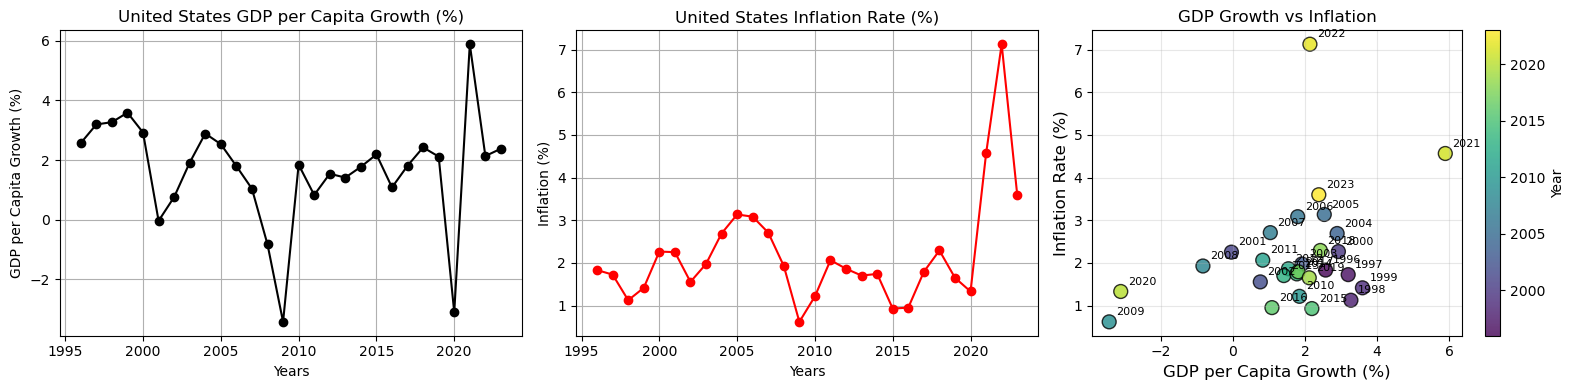

In [32]:
## Cannot use plt directly on Spark Dataframe
gdp_pd = US_gdp.select([str(year) for year in range(1996, 2024)]).toPandas().iloc[0].astype(float).values
inf_pd = US_inf.select([str(year) for year in range(1996, 2024)]).toPandas().iloc[0].astype(float).values

fig, axes = plt.subplots(1, 3, figsize=(16,4))
years = list(range(1996, 2024))

# United States GDP per Capita Growth (%)
axes[0].plot(years, gdp_pd, marker='o', linestyle='-', color='black')
axes[0].set_title("United States GDP per Capita Growth (%)")
axes[0].set_xlabel("Years")
axes[0].set_ylabel("GDP per Capita Growth (%)")
axes[0].grid(True)

# United States Inflation Rate (%) 
axes[1].plot(years, inf_pd, marker='o', linestyle='-', color='red')
axes[1].set_title("United States Inflation Rate (%)")
axes[1].set_xlabel("Years")
axes[1].set_ylabel("Inflation (%)")
axes[1].grid(True)

scatter = axes[2].scatter(gdp_pd, inf_pd, c=years, 
                         cmap='viridis', s=100, alpha=0.8, edgecolors='black')
for i, year in enumerate(years):
    axes[2].annotate(str(year), (gdp_pd[i], inf_pd[i]), 
                     xytext=(5, 5), textcoords='offset points', fontsize=8)

axes[2].set_xlabel('GDP per Capita Growth (%)', fontsize=12)
axes[2].set_ylabel('Inflation Rate (%)', fontsize=12)
axes[2].set_title('GDP Growth vs Inflation', fontsize=12)
axes[2].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[2], label='Year')

plt.tight_layout()
plt.show()

